In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
client = Client(n_workers=10,threads_per_worker=10,processes=True)
client

/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36009 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:36519 Dashboard: http://127.0.0.1:36009/status,Cluster Workers: 10 Cores: 100 Memory: 67.54 GB


# User input

In [2]:
# directory with input data
diri = "/maloney-scratch/joedhsu/proj1/data/sst_locking/"

# input file name.  code assumes full time seires in single file
fili = "SPCCSM3.TS.daily.0004-0023.nc"

# directory for output data
diro = "/maloney-scratch/joedhsu/proj1/data/sst_locking/"

#  output filename prefix (usually includes model and/or simulation details)
Center = "NCAR"

#  output filename prefix (usually includes model and/or simulation details)
Model = "SPCCSM"

# time coordinate variable name
timeName = "time" # units should be similar to "days since YYYY-MM-DD" or "hours since YYYY-MM-DD-HH:MM"

# longitude coordinate variable name
lonName = "lon"

# latitude coordinate variable name
latName = "lat"

#  surface temperature or equivalent variable name
varName = "TS"

#  land surface included?  Enter True or False (no quotation marks)
landData = True

#  skin temperature or foundation temperature?  enter "skin" or "foundation" (inlcude quotes)
sstType = "skin"

#  number of days per year (typically 365, sometimes 360)
DaysPerYear = 365 # some models have 360-day years.  Use 365 if Leap Days included

# Data IO

In [3]:
ds = xr.open_dataset(diri+fili,use_cftime=True)

In [4]:
# ----- skin or foundation SST?
if sstType != "skin" and sstType != "foundation" : 
    print("********* ABORT.  sstType is case-sensitive")
    print("          Must be 'skin' or 'foundation'")

if sstType == "foundation" :
    ds[varName] = ds[varName] - 0.2 # estimate skin SST from foundation SST (C. A Clayson, personal communication)

# Land masking

In [5]:
from ocean_mask import ocn_mask
 
da_omask_regrid = ocn_mask(ds[varName])
da_lmask_regrid = da_omask_regrid.where(da_omask_regrid.notnull(),other=2)-1
da_lmask_regrid = da_lmask_regrid.where(da_lmask_regrid==1, other=0)

/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xarray/core/dataarray.py:738: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


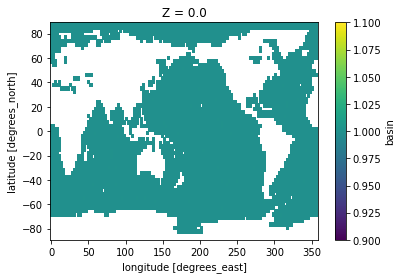

In [6]:
da_omask_regrid.plot()

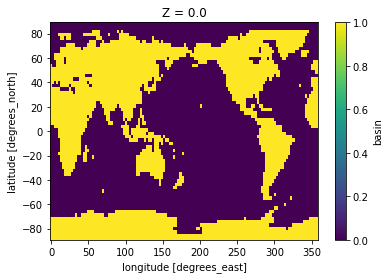

In [7]:
da_lmask_regrid.plot()

In [8]:
ds['%s_ocn'%varName] = ds[varName]*da_omask_regrid

# Calculate background signal

In [9]:
import importlib
import lanczos_filter
importlib.reload(lanczos_filter)
import lanczos_filter as lf

ds['%s_ocn_mean'%varName] = ds['%s_ocn'%varName].mean(dim=timeName)
ds['%s_ocn_nomean'%varName] = ds['%s_ocn'%varName]-ds['%s_ocn_mean'%varName]
ds['%s_ocn_bg'%varName] = lf.lanczos_low_pass(ds['%s_ocn_nomean'%varName], 201, 1/100., dim=timeName,opt='symm')+ds['%s_ocn_mean'%varName]
ds['%s_ocn_anom'%varName] = ds['%s_ocn'%varName]-ds['%s_ocn_bg'%varName]

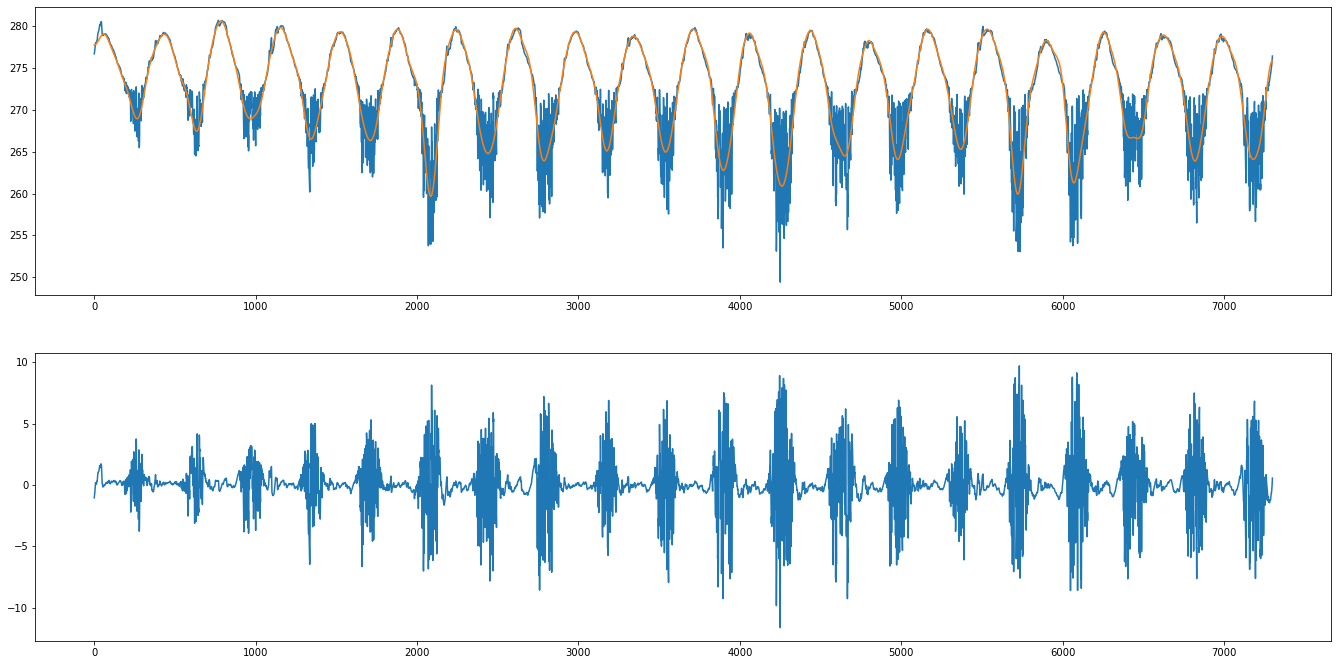

In [10]:
import matplotlib.pyplot as plt

#### plotting
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
da_ori = ds['%s_ocn'%varName].isel(lon=20,lat=10)
da_test = ds['%s_ocn_bg'%varName].isel(lon=20,lat=10)
ax1.plot(da_ori.values)
ax1.plot(da_test.values)
ax2=fig.add_axes([0,-1.2,3,1])
da_ori = ds['%s_ocn_anom'%varName].isel(lon=20,lat=10)
ax2.plot(da_ori.values)

In [11]:
ds = ds.transpose(latName,lonName,timeName)
ds['dayofyear']=ds['%s.dayofyear'%timeName]

# Random Pattern

In [12]:
import random

da_randpatt = ds['%s_ocn_anom'%varName].copy()*np.nan

In [13]:
# %%time
# for i in range(1,DaysPerYear+1):
#     dayindex = np.where(ds['%s.dayofyear'%timeName].values==i)[0]
#     newindex = np.copy(dayindex)
#     random.shuffle(dayindex)
#     da_randpatt[:,:,list(newindex)] = ds['%s_ocn_anom'%varName][:,:,list(dayindex)].values

In [14]:
# da_randpatt = ds['%s_ocn_anom'%varName].copy()*np.nan

In [15]:
%%time
newindex_list = []
for i in range(1,DaysPerYear+1):
    newindex_list.append(np.where(ds['dayofyear']==i)[0])
    
newindex_all = []
newindex_all = np.array(np.append(newindex_all,newindex_list),dtype=int)

CPU times: user 183 ms, sys: 19.9 ms, total: 203 ms
Wall time: 190 ms


In [16]:
%%time
for i in range(DaysPerYear):
    dayindex = np.copy(newindex_list[i])
    random.shuffle(dayindex)
    da_randpatt[:,:,newindex_list[i]] = ds['%s_ocn_anom'%varName][:,:,dayindex].values

CPU times: user 1.38 s, sys: 15.7 ms, total: 1.4 s
Wall time: 1.27 s


# Putting Land points back

In [17]:
ds['RandPatt1d'] = (da_randpatt+ds['%s_ocn_bg'%varName])

if landData :
    ds['RandPatt1d'] = ds['RandPatt1d'].where(ds['RandPatt1d'].notnull(),other=0.)
    
    ds['RandPatt1d'] = da_lmask_regrid*ds['%s'%varName]+ds['RandPatt1d']

# Output file

In [18]:


# AGCM_1dRandPatt
ds_output = xr.Dataset()
ds_output['TS_AGCM_1dRandPatt_bg'] = ds['%s_ocn_bg'%varName] 
ds_output['TS_AGCM_1dRandPatt_anom'] = da_randpatt
ds_output['TS_AGCM_1dRandPatt'] = ds['RandPatt1d']
ds_output.to_netcdf('%s%s.%s.TS.AGCM_1dRandPatt_filtertest.0004-0023.nc'%(diro,Center,Model))